In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


In [2]:
df = pd.read_csv("../../../data/processed/nvda_target_updown.csv")
df

,date,open,high,low,close,adj_close,volume,daily_return,adj_close_lag1,adj_close_lag2,...,BB_mid,BB_width,ATR_14,OBV,Volume_SMA_20,MFI_14,Close_to_EMA20,High_Low_Spread,y_price_return_1d,y_updown_1d
0,2020-03-19,5.049000,5.418250,4.834750,5.324250,5.304039,765512000,0.050045,5.051251,5.411129,...,6.257187,2.741390,0.540013,1159492000,750560400.0,45.562807,-0.120441,0.109593,-0.033901,-1
1,2020-03-20,5.475000,5.758000,5.128250,5.143750,5.124224,804636000,-0.033901,5.304039,5.051251,...,6.147425,2.728845,0.546423,354856000,752383200.0,43.839374,-0.137923,0.122430,0.033730,1
2,2020-03-23,5.142750,5.412000,4.963000,5.317250,5.297065,643876000,0.033730,5.124224,5.304039,...,6.072178,2.755308,0.539464,998732000,741731200.0,44.675916,-0.099510,0.084442,0.171564,1
3,2020-03-24,5.725000,6.316500,5.701250,6.229500,6.205852,1101644000,0.171564,5.297065,5.124224,...,6.056347,2.727598,0.572306,2100376000,744038600.0,47.146285,0.049486,0.098764,-0.014287,-1
4,2020-03-25,6.345000,6.545500,6.091500,6.140500,6.117191,793432000,-0.014287,6.205852,5.297065,...,6.029113,2.671622,0.563856,1306944000,746323600.0,54.699045,0.031105,0.073935,0.047309,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,2025-11-10,195.110001,199.940002,193.789993,199.050003,199.050003,198897100,0.057933,188.149994,188.080002,...,190.919501,38.096850,7.509215,54638461200,188849325.0,57.590249,0.033893,0.030897,-0.029591,-1
1420,2025-11-11,195.160004,195.419998,191.300003,193.160004,193.160004,176483300,-0.029591,199.050003,188.149994,...,191.576001,36.791643,7.526414,54461977900,187391420.0,57.073952,0.002985,0.021329,0.003313,0
1421,2025-11-12,195.720001,195.889999,191.130005,193.800003,193.800003,154935300,0.003313,193.160004,199.050003,...,192.274501,35.205123,7.328813,54616913200,184415660.0,57.830202,0.005704,0.024561,-0.035810,-1
1422,2025-11-13,191.050003,191.440002,183.850006,186.860001,186.860001,207423100,-0.035810,193.800003,193.160004,...,192.527001,34.267030,7.516040,54409490100,185800650.0,52.070726,-0.027503,0.040619,0.017714,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1424 non-null   object 
 1   open               1424 non-null   float64
 2   high               1424 non-null   float64
 3   low                1424 non-null   float64
 4   close              1424 non-null   float64
 5   adj_close          1424 non-null   float64
 6   volume             1424 non-null   int64  
 7   daily_return       1424 non-null   float64
 8   adj_close_lag1     1424 non-null   float64
 9   adj_close_lag2     1424 non-null   float64
 10  adj_close_lag3     1424 non-null   float64
 11  daily_return_lag1  1424 non-null   float64
 12  daily_return_lag2  1424 non-null   float64
 13  daily_return_lag3  1424 non-null   float64
 14  EMA_20             1424 non-null   float64
 15  EMA_50             1424 non-null   float64
 16  MACD               1424 

In [4]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

In [5]:
target_cls = "y_updown_1d"
target_reg = "y_price_return_1d"
features = [c for c in df.columns if c not in (target_cls, target_reg, "date")]

bounded_01 = ["RSI_14", "Stoch_k", "Stoch_d", "MFI_14"]

heavy_pos = ["volume", "Volume_SMA_20", "ATR_14", "BB_width", "High_Low_Spread"]

heavy_signed_obv = ["OBV"]

zero_center_std = [
    "daily_return", "daily_return_lag1", "daily_return_lag2", "daily_return_lag3",
    "MACD", "MACD_signal", "MACD_diff",
    "ROC_10", "Close_to_EMA20",
]

price_like_std = [
    "open", "high", "low", "close", "adj_close",
    "adj_close_lag1", "adj_close_lag2", "adj_close_lag3",
    "EMA_20", "EMA_50", "BB_high", "BB_low", "BB_mid",
]

In [6]:
def signed_log1p(x: pd.Series) -> pd.Series:
    return np.sign(x) * np.log1p(np.abs(x))

X = df.loc[:, features].copy()

# 1) bounded 0-100 -> [0,1]
for c in bounded_01:
    X[c] = X[c] / 100.0

# 2) heavy positive -> log1p then RobustScaler
robust_scaler = RobustScaler()
if heavy_pos:
    X[heavy_pos] = np.log1p(X[heavy_pos].clip(lower=0))
    X[heavy_pos] = robust_scaler.fit_transform(X[heavy_pos])

# 3) OBV -> signed log1p then StandardScaler (or RobustScaler if extremely spiky)
std_obv = StandardScaler()
if heavy_signed_obv:
    X[heavy_signed_obv] = signed_log1p(X[heavy_signed_obv].astype(float))
    X[heavy_signed_obv] = std_obv.fit_transform(X[heavy_signed_obv])

# 4) zero-centered indicators & returns -> StandardScaler
std_zero = StandardScaler()
if zero_center_std:
    X[zero_center_std] = std_zero.fit_transform(X[zero_center_std])

# 5) price-like levels -> StandardScaler  (consider replacing with relative features before this step)
std_price = StandardScaler()
if price_like_std:
    X[price_like_std] = std_price.fit_transform(X[price_like_std])

# 6) LSTM-friendly range on everything (except labels), you can add:
mm_all = MinMaxScaler(feature_range=(-1, 1))
X = mm_all.fit_transform(X)

In [7]:
X

array([[-1.        , -0.99993955, -1.        , ..., -0.19796937,
        -0.75575858,  0.4045063 ],
       [-0.9958036 , -0.99665342, -0.99707561, ..., -0.23868215,
        -0.83696019,  0.57545489],
       [-0.9990765 , -1.        , -0.99872214, ..., -0.21892046,
        -0.65853456,  0.06377367],
       ...,
       [ 0.87824519,  0.84234297,  0.85622145, ...,  0.09182422,
        -0.16981803, -0.78036963],
       [ 0.83224238,  0.79930167,  0.7836845 , ..., -0.04423231,
        -0.32406371, -0.54926381],
       [ 0.75156502,  0.79514254,  0.7511026 , ..., -0.17649022,
        -0.23954287, -0.34746034]], shape=(1424, 32))

In [8]:
y_reg = df[target_reg].copy()
y_reg

0      -0.033901
1       0.033730
2       0.171564
3      -0.014287
4       0.047309
          ...   
1419   -0.029591
1420    0.003313
1421   -0.035810
1422    0.017714
1423         NaN
Name: y_price_return_1d, Length: 1424, dtype: float64

In [9]:
y_cls = df[target_cls].copy()
y_cls

0      -1
1       1
2       1
3      -1
4       1
       ..
1419   -1
1420    0
1421   -1
1422    1
1423    0
Name: y_updown_1d, Length: 1424, dtype: int64

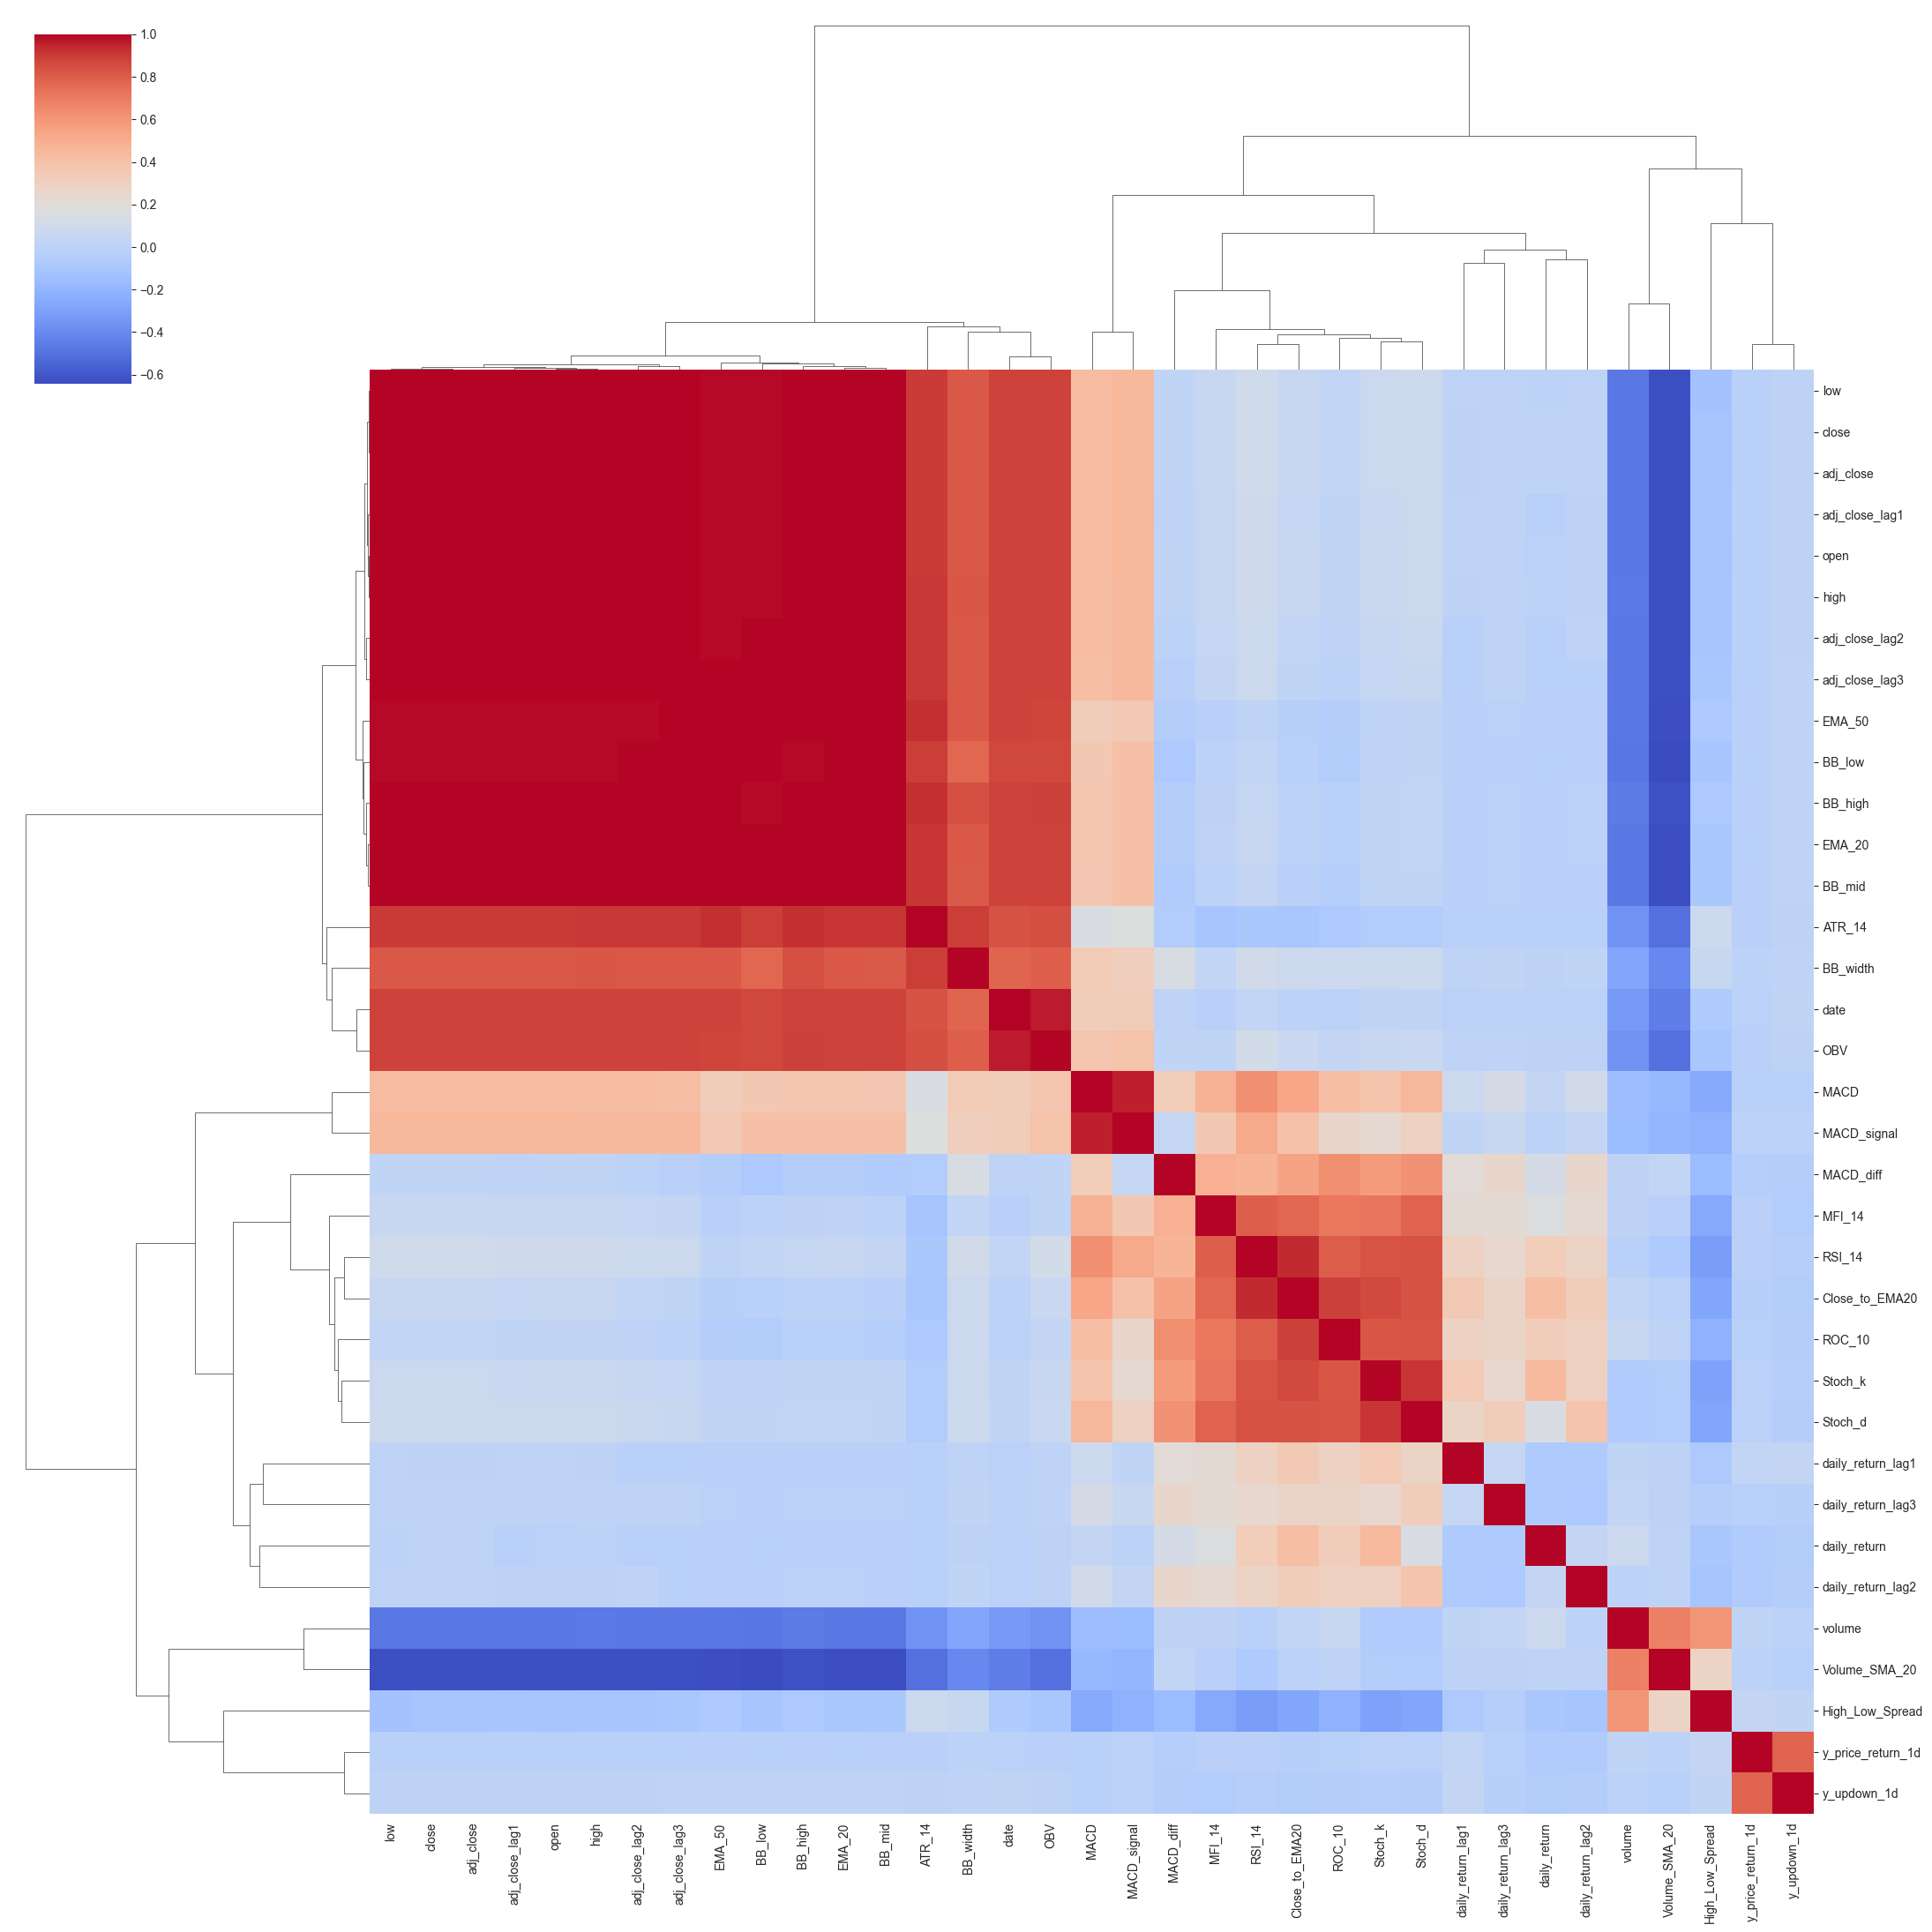

In [12]:
sns.clustermap(df.corr(), cmap="coolwarm", figsize=(22, 22))

<Axes: >

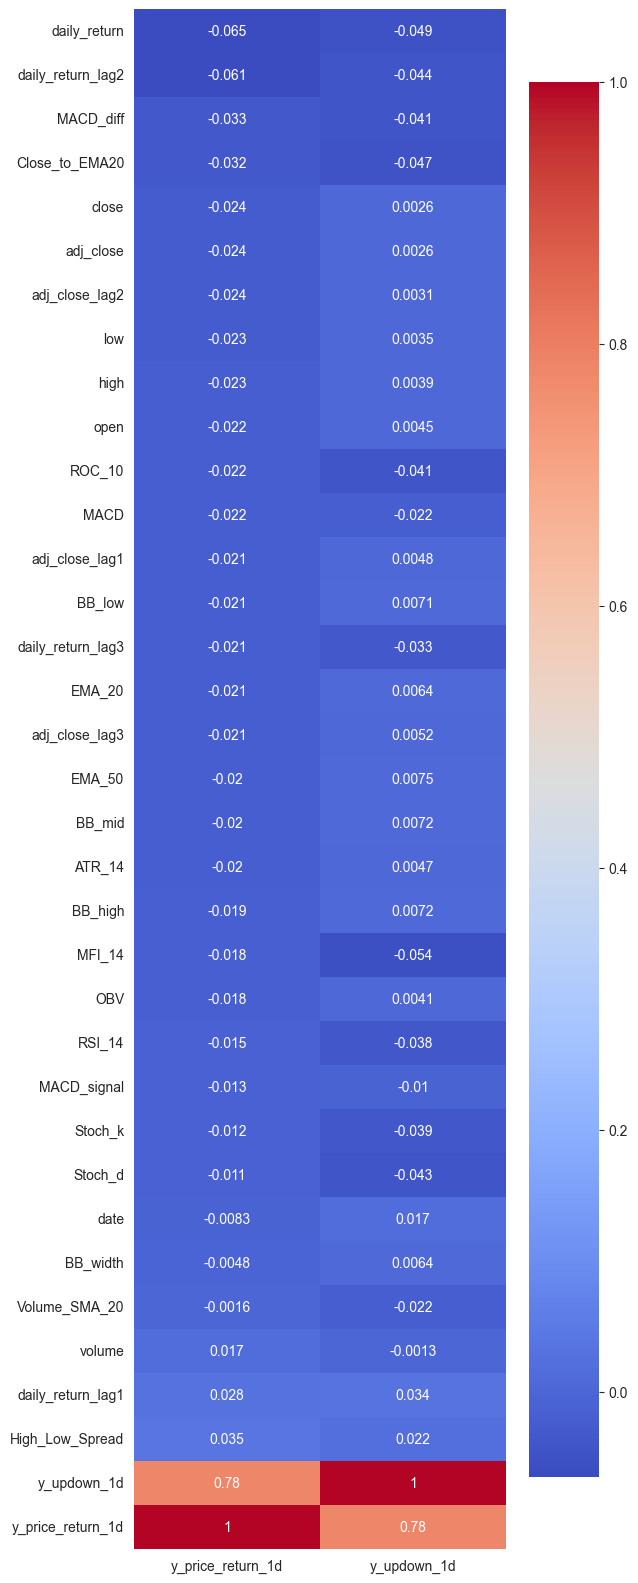

In [15]:
target_corr = df.corr()[["y_price_return_1d", "y_updown_1d"]].sort_values("y_price_return_1d")
plt.figure(figsize=(6, 20))
sns.heatmap(target_corr, annot=True, cmap="coolwarm")